In [1]:
import sys
import os
import numpy as np
import pandas as pd
import random

sys.path.insert(0, "..")
from unpast.run_unpast import unpast
from unpast.utils.io import read_bic_table, write_bic_table
from unpast.utils.method import zscore
from unpast.utils.consensus import make_consensus_biclusters

%matplotlib inline

In [2]:
exprs_file = "../../data/DIP/2_Pelz_timepoint_infos.tsv"
exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
out_dir = "DIP_results/" 

exprs = pd.read_csv(exprs_file,sep="\t",index_col=0)
print(exprs.shape[0])
exprs.head(3)

2098


,VB3-Saat,VB3-7,VB3-8,VB3-9,VB3-13,VB3-14,VB3-15,VB3-16,VB3-17,VB3-22,...,VB3-32,VB3-33,VB3-38,VB3-40,VB3-41,VB3-42,VB3-45,VB3-46,VB3-47,VB3-48
DI,,,,,,,,,,,,,,,,,,,,,
PB2_138_167,64,663,661,1461,1320,1433,1150,2122,1625,1263,...,590,1137,612,716,273,289,592,246,390,477
PB2_117_164,0,19,13,30,49,40,32,93,72,42,...,21,80,75,60,51,39,101,45,62,364
PB2_269_2202,0,0,0,0,3,0,0,0,1,0,...,0,73,25,62,194,343,418,186,308,361


In [3]:
# normalization to library size
lib_size = exprs.sum()
norm_factor = lib_size/10**4
norm_exprs_libsize = exprs / norm_factor.T

# log2(x+1)
norm_exprs_log2 = norm_exprs_libsize.applymap(lambda x: np.log2(x+1))

In [4]:
exprs_file = "../../data/DIP/2_Pelz_timepoint_infos.norm_lib_size_nolog2.tsv"
norm_exprs_libsize.to_csv(exprs_file,sep = "\t")
exprs = pd.read_csv(exprs_file,sep = "\t",index_col=0)
basename = "DIP_norm_nolog2"

In [5]:
cseed = 42
n_runs = 5
seeds = []
random.seed(cseed)
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [670487, 116739, 26225, 777572, 288389]


In [6]:
# run unpast, make consensus, save to file:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                          out_dir=out_dir,
                          save=True, load=True,
                          seed = seed,
                          verbose = False)
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    
consensus_biclusters = make_consensus_biclusters(biclusters,
                                                 zscore(exprs),
                                                 seed = cseed,
                                                 plot = False,
                                                 verbose = False
                                                 )
consensus_biclusters = consensus_biclusters.loc[consensus_biclusters["detected_n_times"]>2,:]

suffix = ".consensus_seed=42.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv"
#write_bic_table(consensus_biclusters,out_dir+basename+suffix)


# or read pre-computed biclusters from file:
#consensus_biclusters = read_bic_table("../../data/DIP/results/"+basename+suffix)

colors: ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133']


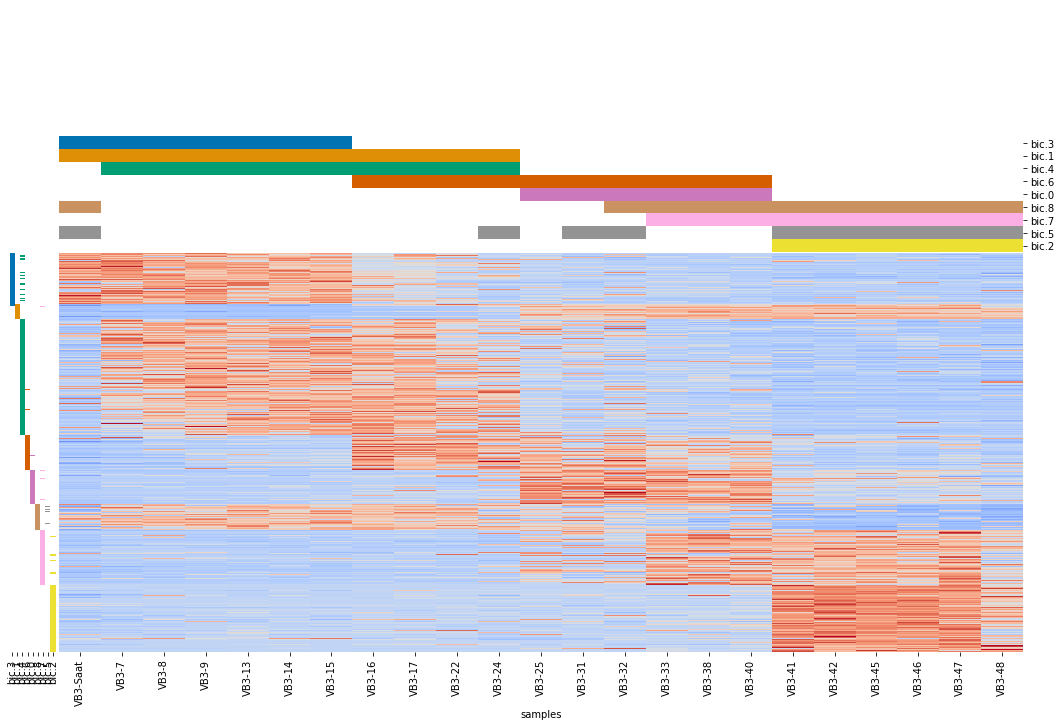

In [10]:
from unpast.utils.figs import  draw_heatmap2
sele_biclusters = consensus_biclusters.loc[[3,1,4,6,0,8,7,5,2],:] # 

features = set([])
for fset in [sele_biclusters.loc[x,"genes"] for x in sele_biclusters.index.values]:
    features|=fset
features = list(features)

tmp = draw_heatmap2(zscore(exprs.loc[features,:]),
                    sele_biclusters,
                    figsize=(15,10),
                    no_row_colors = False,
                    cluster_rows=False,
                    no_cbar=True,
                    cluster_columns=False,
                    bicluster_colors = "auto",
                    bic_prefix="bic.")